In [1]:
# Checking colab GPU availability
import torch
print(torch.cuda.is_available())

True


In [2]:
# Importing required libraries
import zipfile
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import h5py
import seaborn as sns
import time
import random
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [3]:
# Loading dataset
from google.colab import drive
drive.mount('/content/drive')

# Dataset file
zip_file_name = "/content/drive/MyDrive/trafficsign_dataset.zip"

# Unzipping the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content/trafficsign_dataset")



Mounted at /content/drive


In [4]:
# Removing Bias from the Dataset
data_dir = "trafficsign_dataset/Dataset"

# Delete extra images in classes with more than 350 images
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_images = os.listdir(class_path)
        if len(class_images) > 500:
            # Randomly select 500 images
            images_to_keep = random.sample(class_images, 500)
            for image in class_images:
                if image not in images_to_keep:
                    os.remove(os.path.join(class_path, image))


In [5]:
# Splitting the Dataset

# original dataset directory
original_dataset_dir = 'trafficsign_dataset/Dataset'
# split dataset directory
base_dir = 'trafficsign_dataset_split'
# creating directory if does not exists
os.makedirs(base_dir, exist_ok=True)

# Split ratio
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Function to copy the files to the new location
def copy_files(files, dest_folder, label):
    for file in files:
        shutil.copy(file, os.path.join(base_dir, dest_folder, label))

# Function to split data and move into corresponding folders
def split_data(original_dataset_dir, base_dir, train_size, valid_size, test_size):
    labels = [label for label in os.listdir(original_dataset_dir) if not label.startswith('.')]

    for label in labels:
        # Creating subdirectories for train, validation, and test within each label's folder if not exists
        os.makedirs(os.path.join(base_dir, 'train', label), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'valid', label), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'test', label), exist_ok=True)

        # Getting all image files under current label
        label_path = os.path.join(original_dataset_dir, label)
        files = [os.path.join(label_path, f) for f in os.listdir(label_path) if not f.startswith('.')]  # Exclude hidden files

        # Splitting image files into training, validation, and test sets
        train_files, test_files = train_test_split(files, test_size=0.2)
        valid_files, test_files = train_test_split(test_files, test_size=0.5)

        # Copying the files to its respective directories
        copy_files(train_files, 'train', label)
        copy_files(valid_files, 'valid', label)
        copy_files(test_files, 'test', label)

split_data(original_dataset_dir, base_dir, train_ratio, validation_ratio, test_ratio)

print(f"Split completed. Check the contents in '{base_dir}' directory.")


Split completed. Check the contents in 'trafficsign_dataset_split' directory.


In [6]:
# PreProcessing Image files in the dataset

# directory where the preprocessed data will be stored
preprocessed_base_dir = 'preprocessed_trafficsign_dataset_split'
os.makedirs(preprocessed_base_dir, exist_ok=True)

# Function to Preprocess images
def preprocess_images(input_dir, output_dir):
    labels = os.listdir(input_dir)
    print(labels)
    for label in labels:
        input_label_dir = os.path.join(input_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        os.makedirs(output_label_dir, exist_ok=True)

        # Process images under current label directory
        for filename in os.listdir(input_label_dir):
            img_path = os.path.join(input_label_dir, filename)
            output_path = os.path.join(output_label_dir, filename)

            # Open and preprocess the image
            with Image.open(img_path) as img:
                # Resizing the image to 64x64
                img = img.resize((64, 64))

                # Normalize pixel values to be between 0 and 1
                img_array = np.array(img) / 255.0

                # Saving the preprocessed image
                preprocessed_img = Image.fromarray((img_array * 255).astype('uint8'))
                preprocessed_img.save(output_path)

# Preprocess train, valid, and test sets
preprocess_images('trafficsign_dataset_split/train', os.path.join(preprocessed_base_dir, 'train'))
preprocess_images('trafficsign_dataset_split/valid', os.path.join(preprocessed_base_dir, 'valid'))
preprocess_images('trafficsign_dataset_split/test', os.path.join(preprocessed_base_dir, 'test'))

print(f"Image preprocessing completed. Preprocessed data is saved in '{preprocessed_base_dir}' directory.")


['9', '18', '31', '34', '27', '24', '33', '38', '4', '2', '7', '20', '0', '35', '41', '12', '13', '11', '39', '23', '32', '15', '42', '16', '17', '21', '36', '14', '40', '19', '25', '8', '26', '28', '30', '3', '10', '5', '37', '6', '29', '1', '22']
['9', '18', '31', '34', '27', '24', '33', '38', '4', '2', '7', '20', '0', '35', '41', '12', '13', '11', '39', '23', '32', '15', '42', '16', '17', '21', '36', '14', '40', '19', '25', '8', '26', '28', '30', '3', '10', '5', '37', '6', '29', '1', '22']
['9', '18', '31', '34', '27', '24', '33', '38', '4', '2', '7', '20', '0', '35', '41', '12', '13', '11', '39', '23', '32', '15', '42', '16', '17', '21', '36', '14', '40', '19', '25', '8', '26', '28', '30', '3', '10', '5', '37', '6', '29', '1', '22']
Image preprocessing completed. Preprocessed data is saved in 'preprocessed_trafficsign_dataset_split' directory.


In [7]:
# Transforming images data to tensors and preparing data loaders

transform = transforms.Compose([
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

train_directory = '/content/preprocessed_trafficsign_dataset_split/train'
val_directory = '/content/preprocessed_trafficsign_dataset_split/valid'
test_directory = '/content/preprocessed_trafficsign_dataset_split/test'

# Creating Training , validation and testing datasets
trainSet = torchvision.datasets.ImageFolder(root=train_directory, transform=transform)
valSet =  torchvision.datasets.ImageFolder(root=val_directory, transform=transform)
testSet = torchvision.datasets.ImageFolder(root=test_directory, transform =transform)

print(trainSet)

# Creating the dataLoaders
train_loader = DataLoader(trainSet,batch_size=64, shuffle=True)
val_loader = DataLoader(valSet,batch_size=64, shuffle=True)
test_loader = DataLoader(testSet,batch_size=64, shuffle=True)

Dataset ImageFolder
    Number of datapoints: 13648
    Root location: /content/preprocessed_trafficsign_dataset_split/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0}


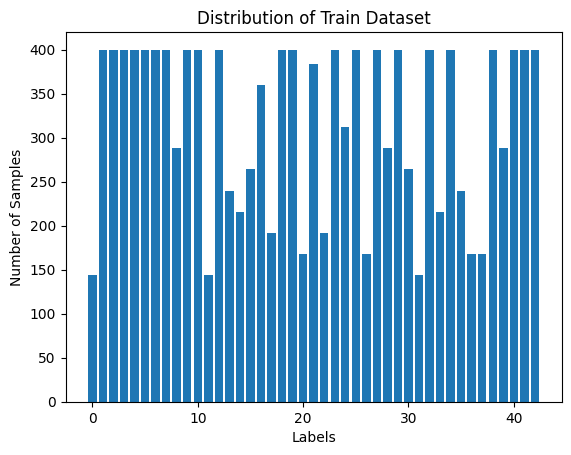

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0}


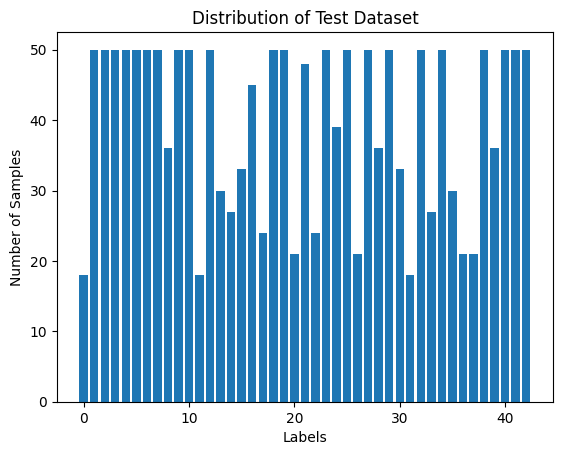

In [8]:
num_classes=43
def plot_data_distribution(loader, loader_name):
    label_count = {i: 0 for i in range(num_classes)}
    print(label_count)
    for _, labels in loader:
        for label in labels.numpy():
            label_count[label] += 1

    labels = list(label_count.keys())
    count = list(label_count.values())

    # Plotting graph
    fig, ax = plt.subplots()
    ax.bar(labels, count)
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Distribution of {loader_name} Dataset')
    plt.show()

# Plot Data distribution of loaders
plot_data_distribution(train_loader, "Train")
plot_data_distribution(test_loader, "Test")

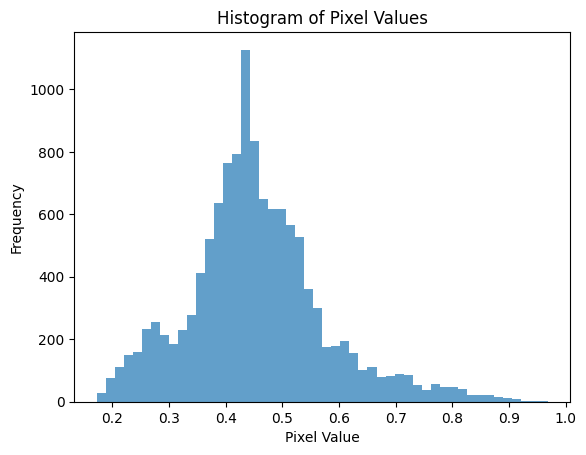

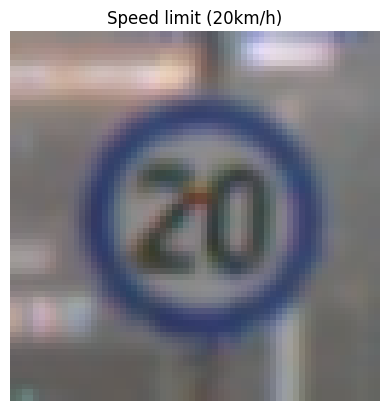

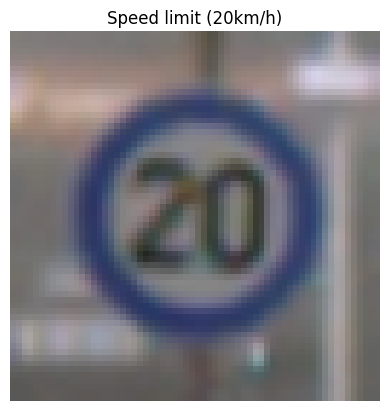

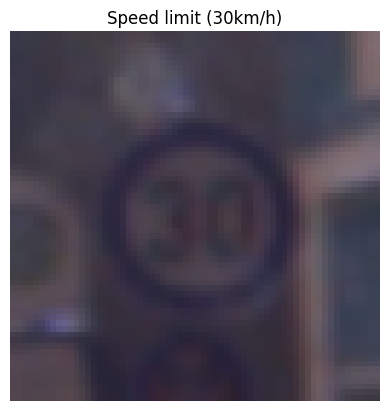

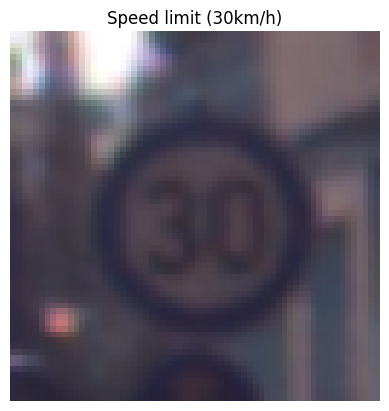

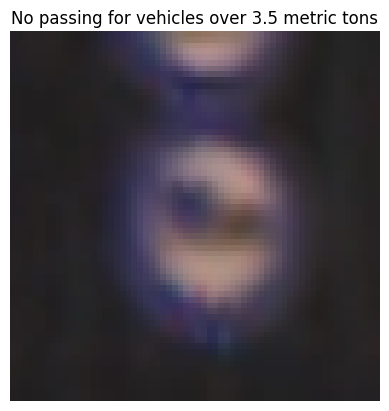

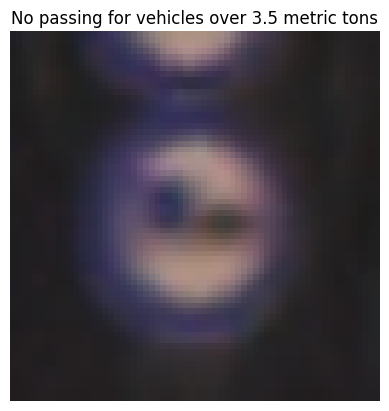

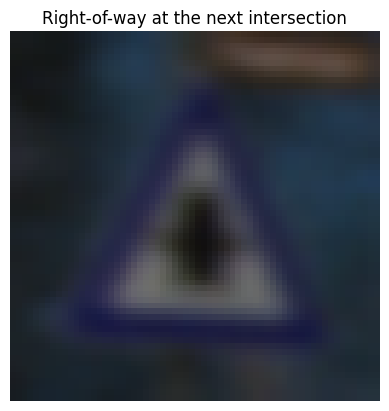

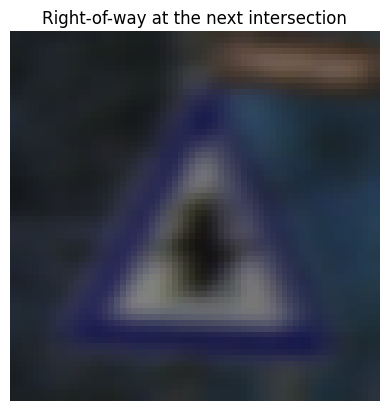

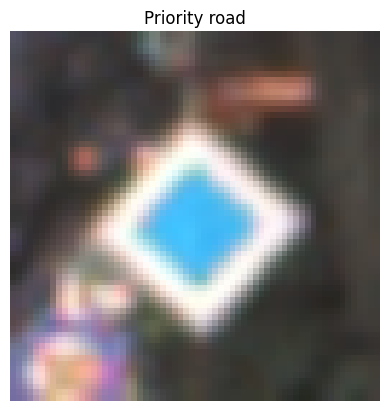

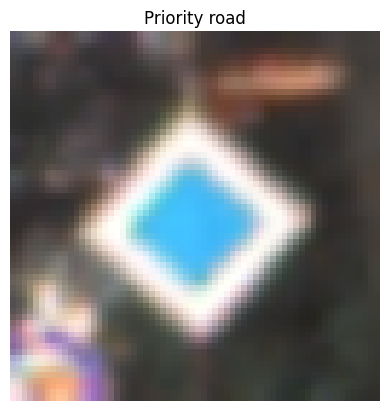

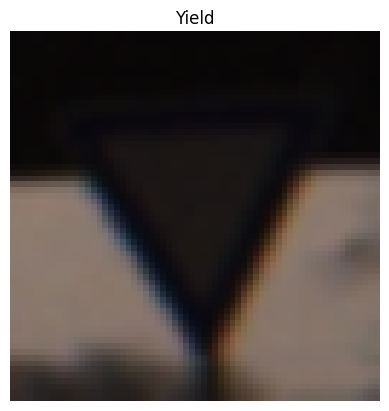

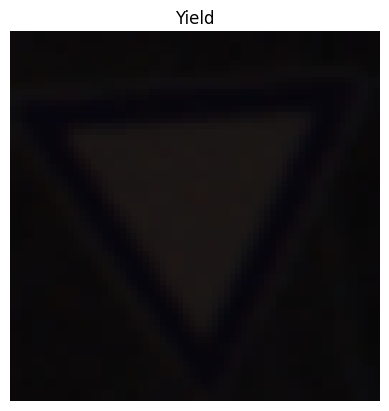

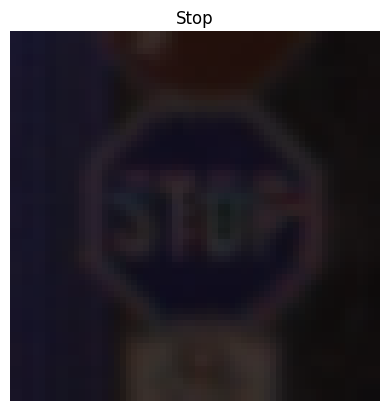

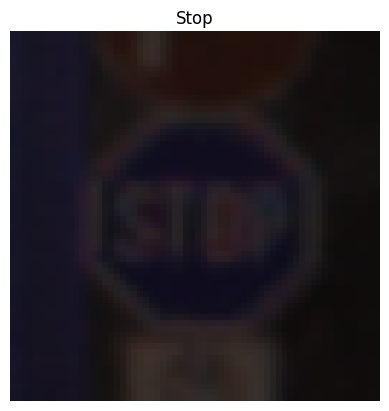

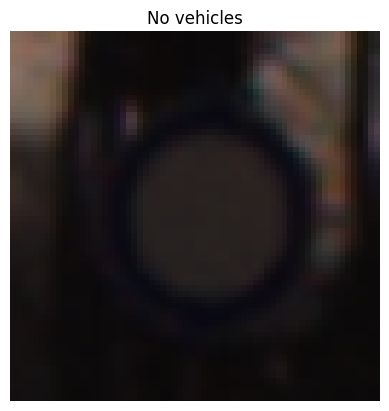

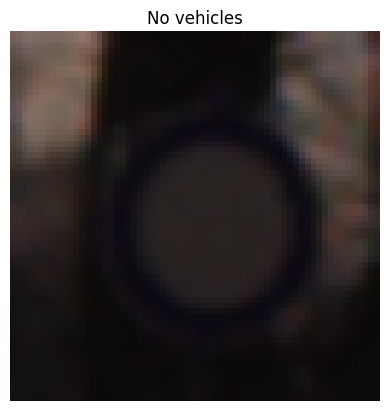

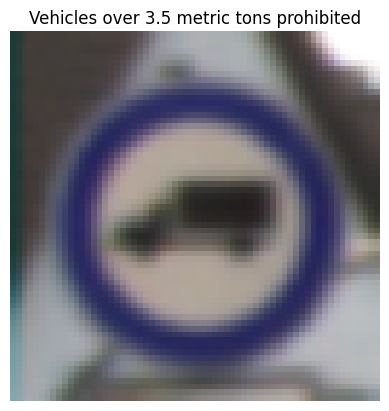

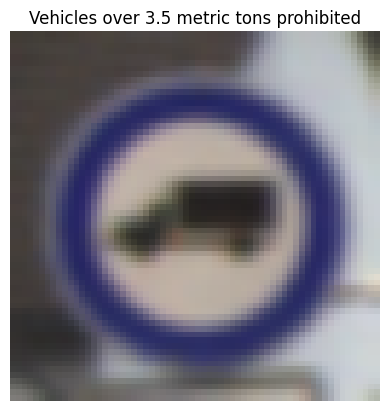

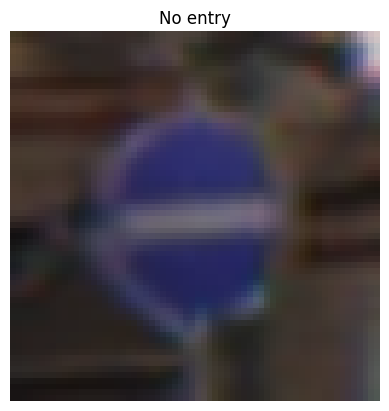

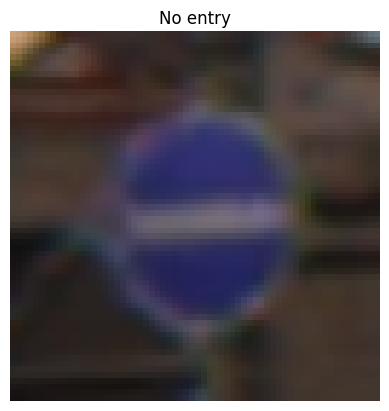

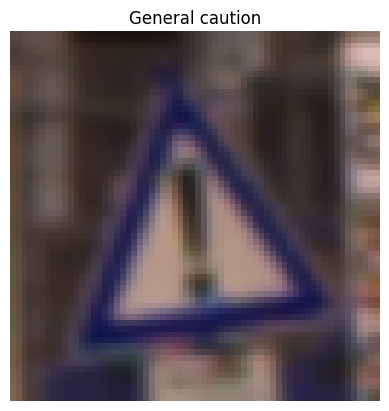

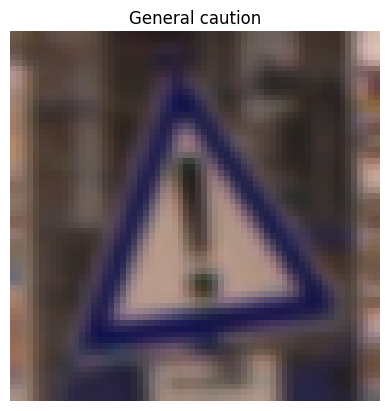

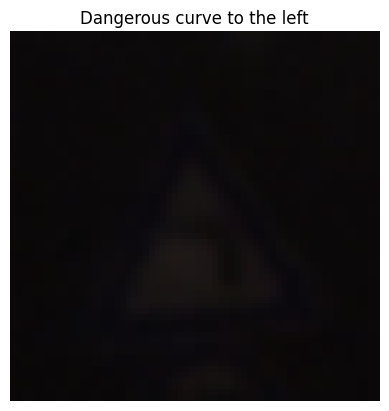

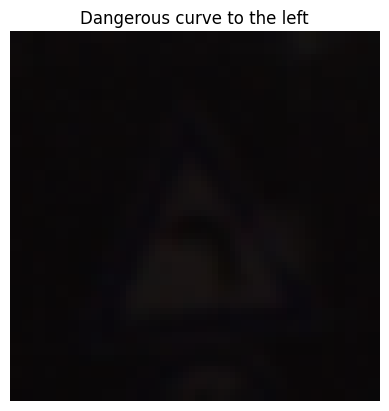

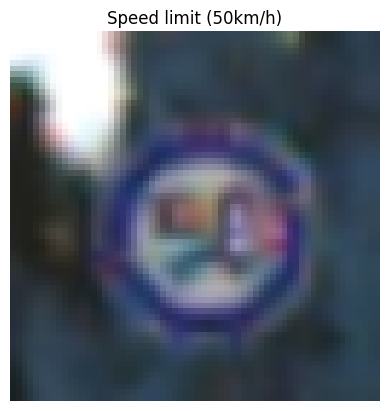

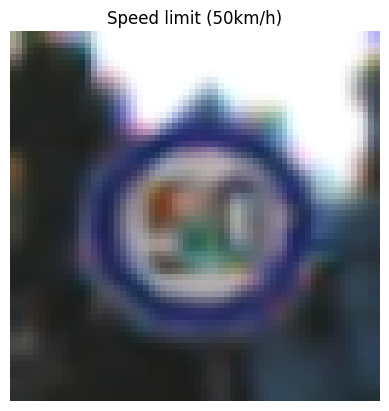

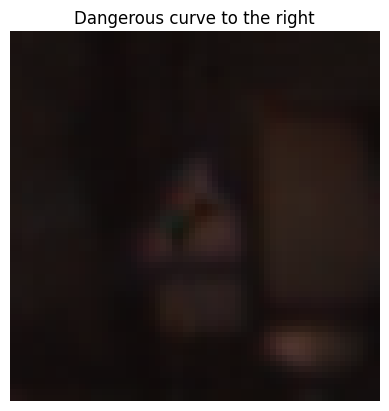

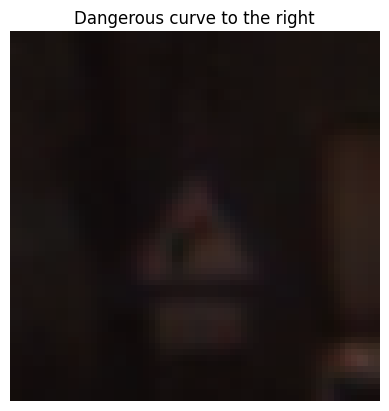

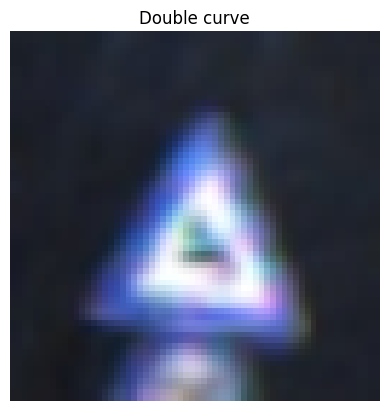

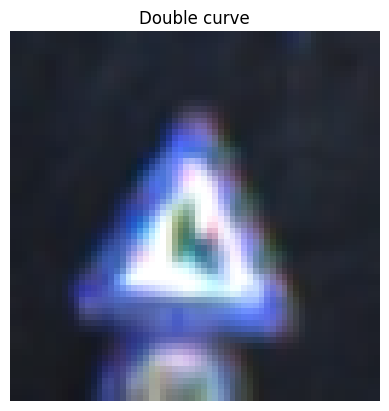

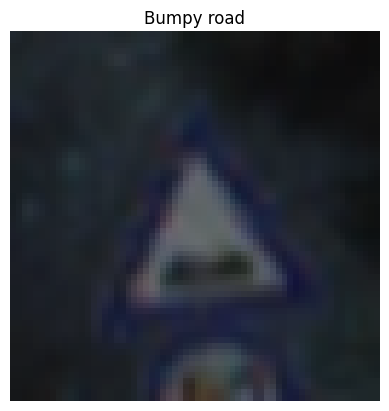

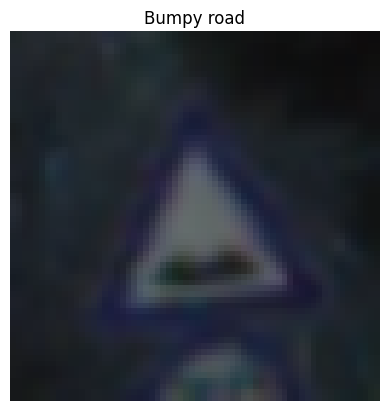

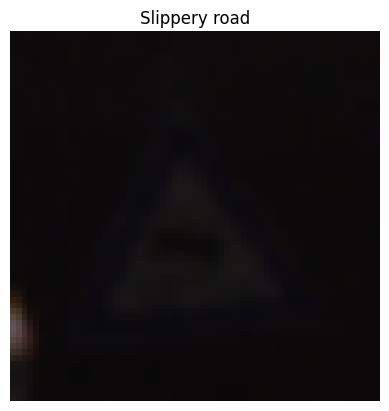

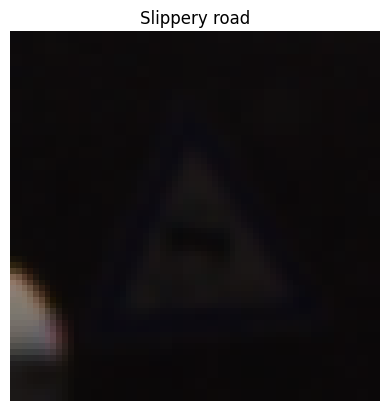

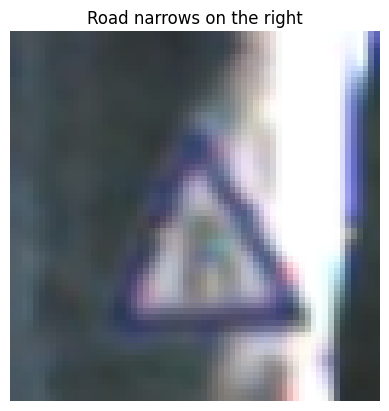

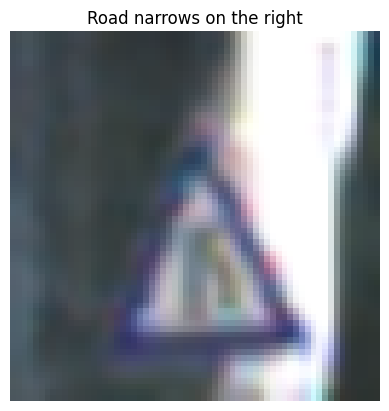

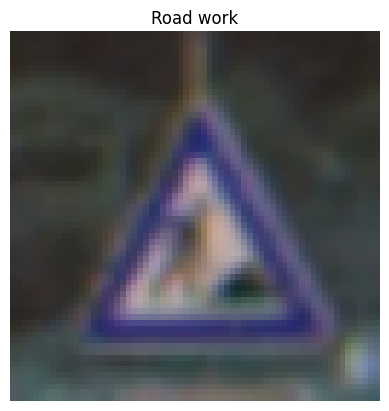

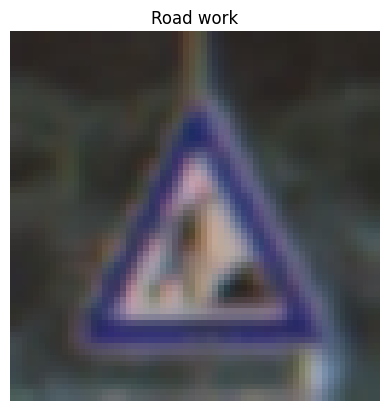

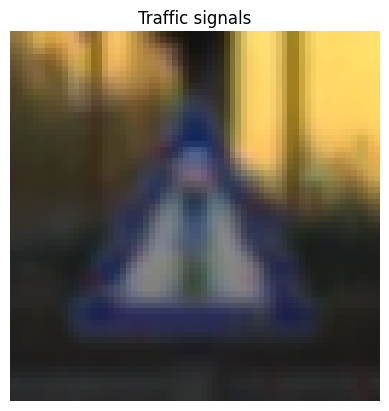

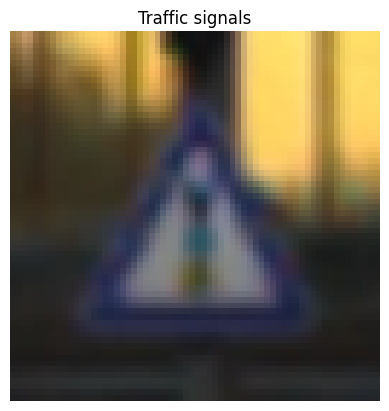

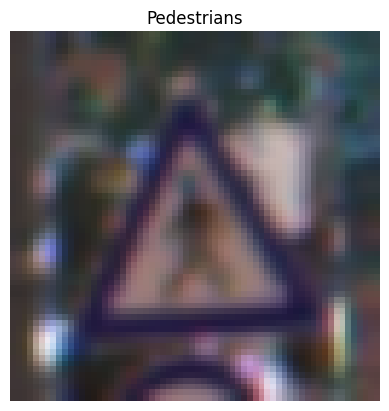

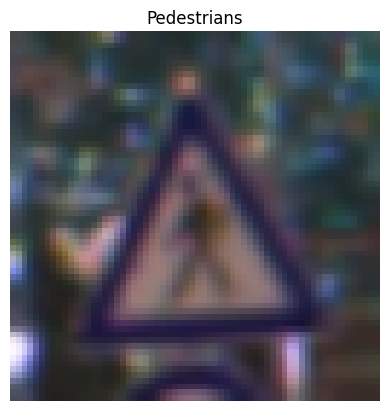

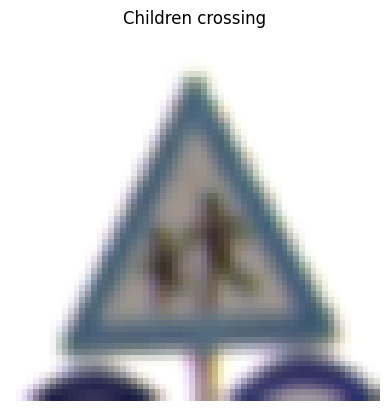

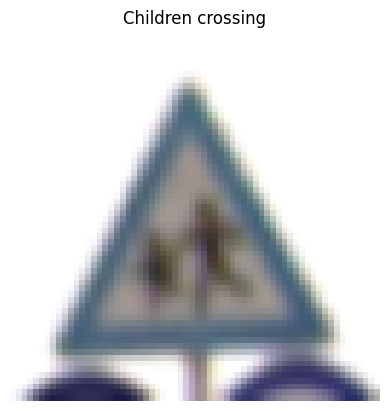

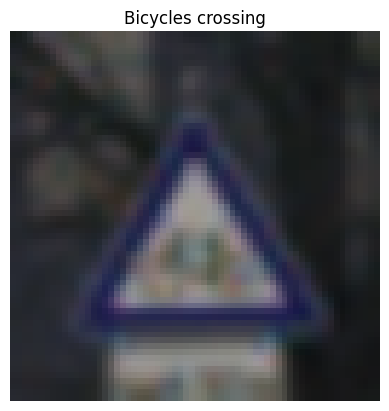

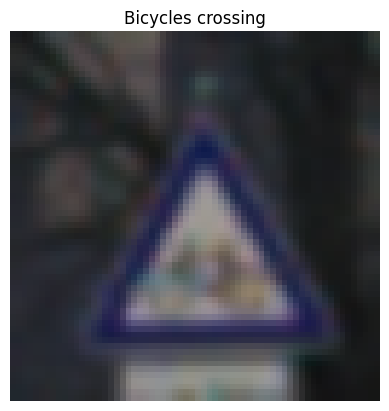

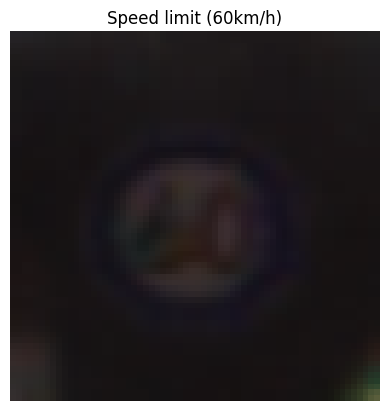

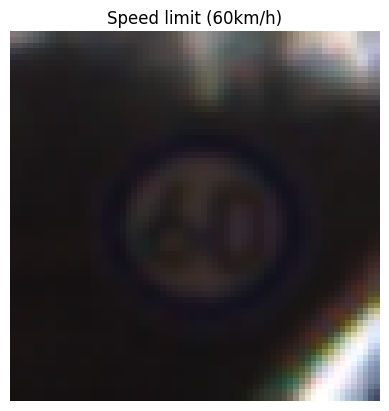

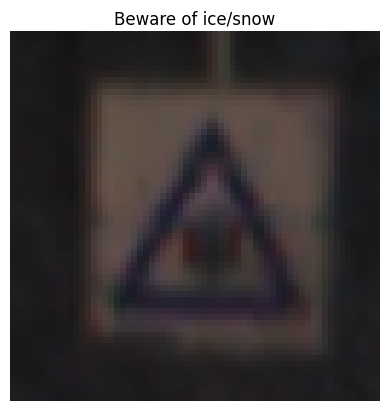

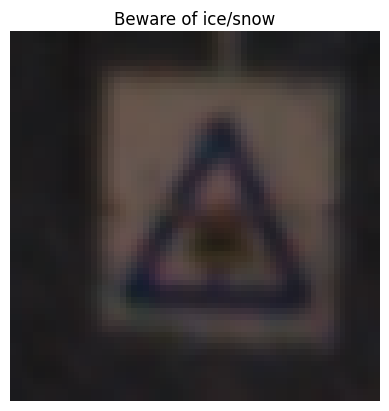

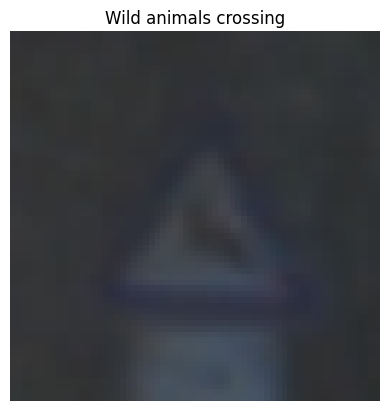

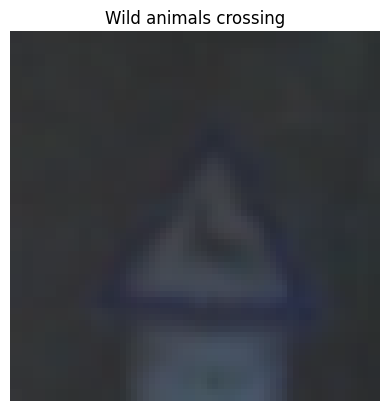

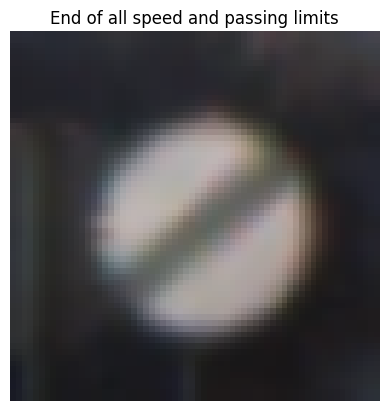

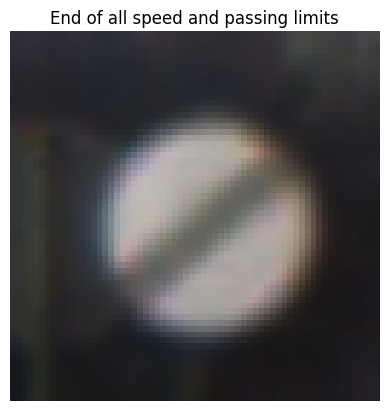

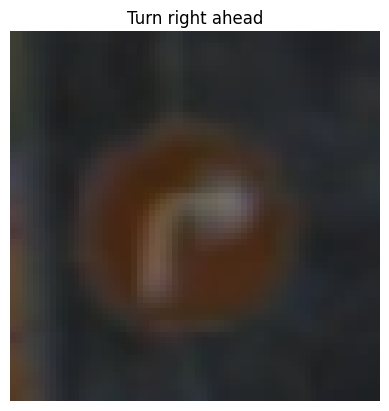

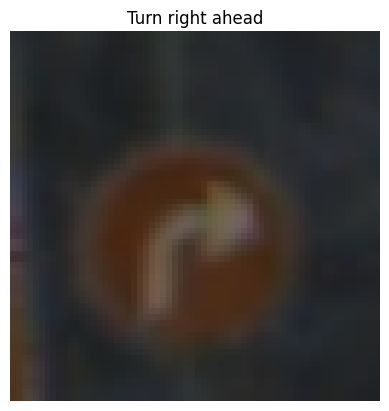

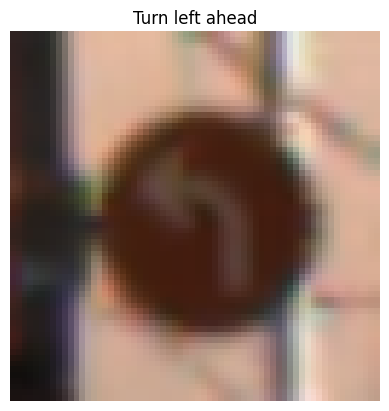

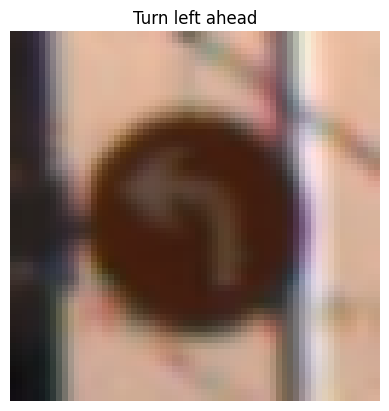

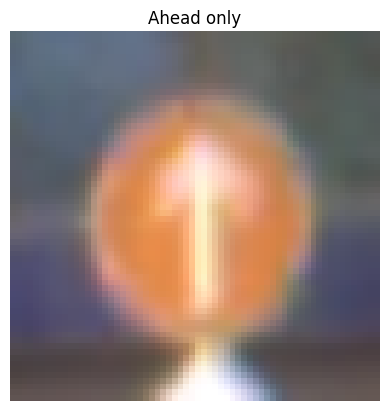

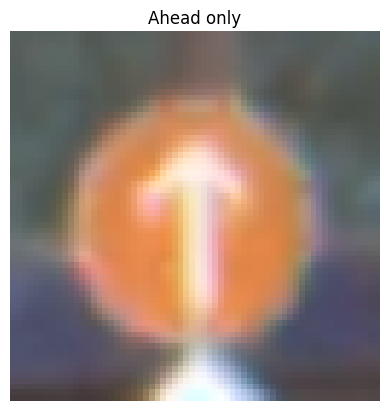

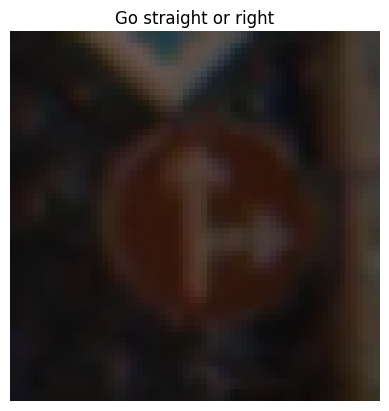

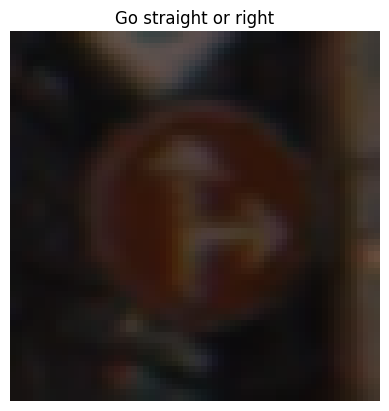

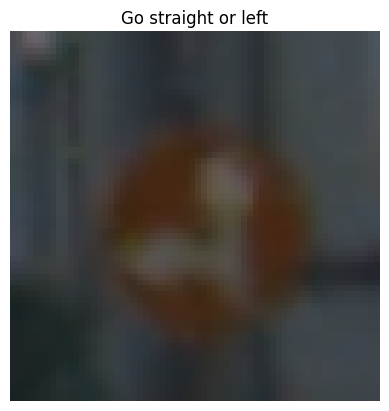

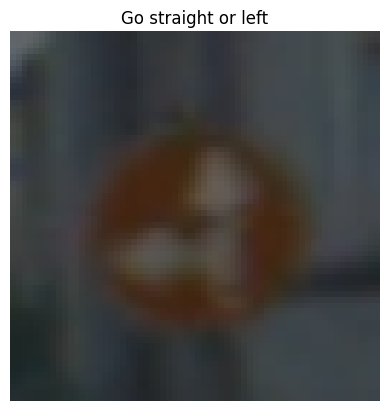

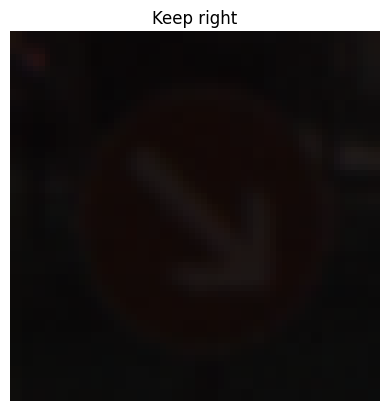

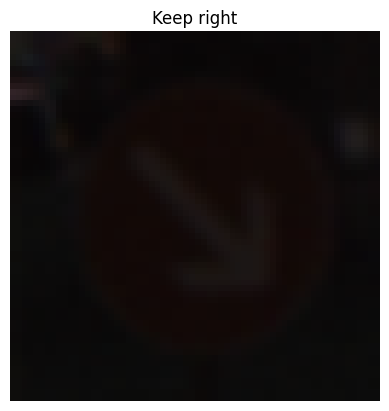

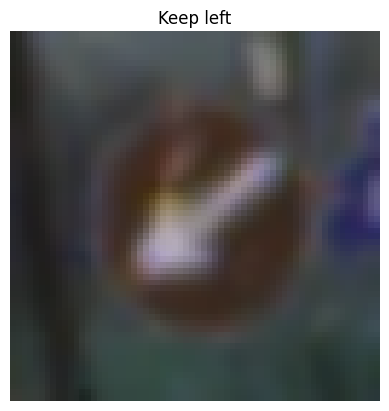

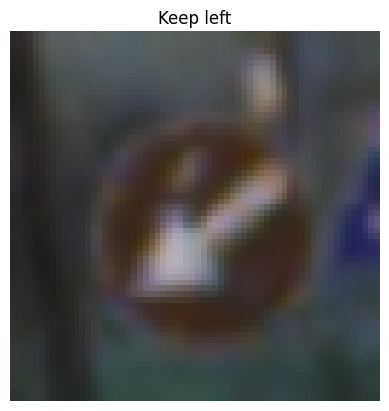

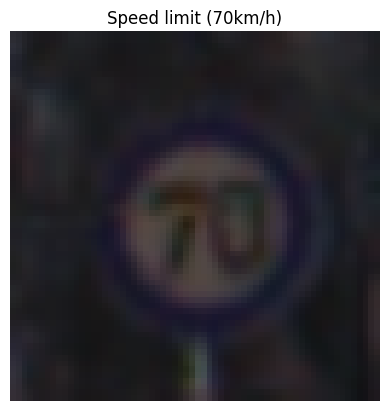

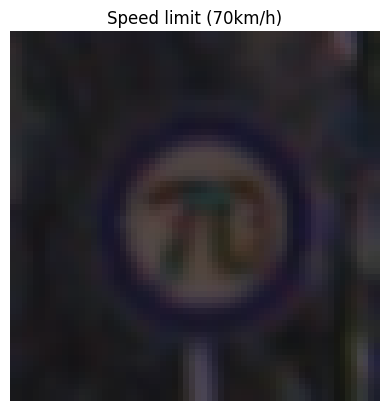

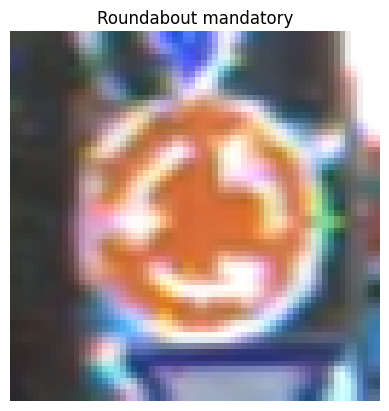

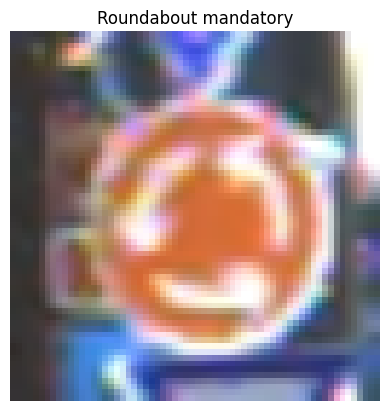

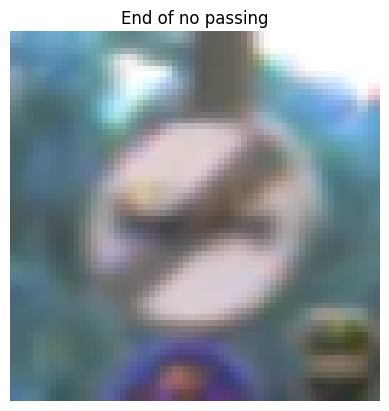

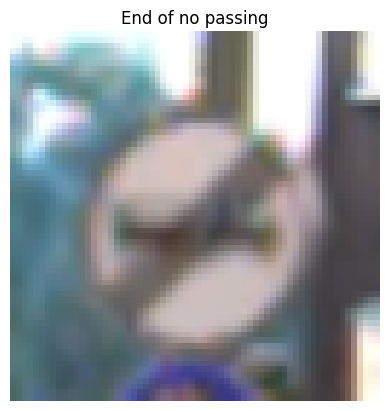

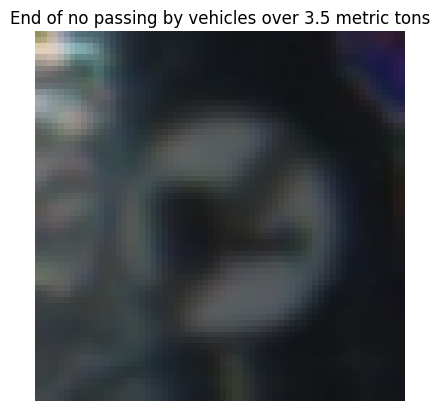

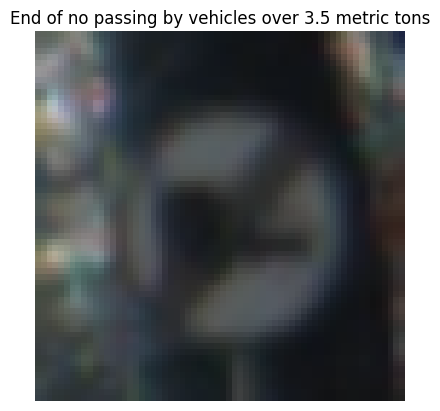

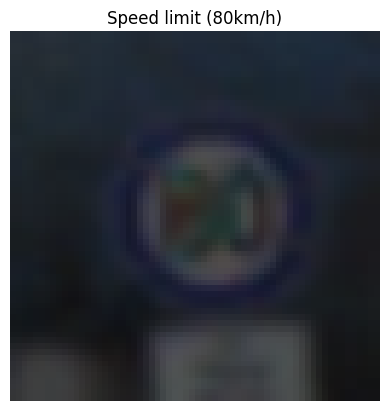

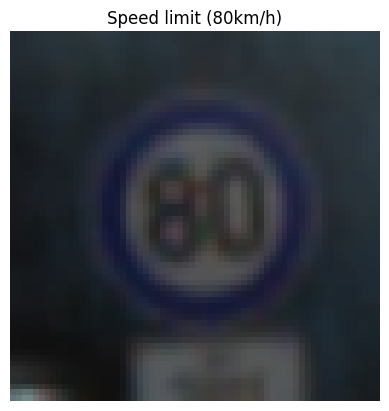

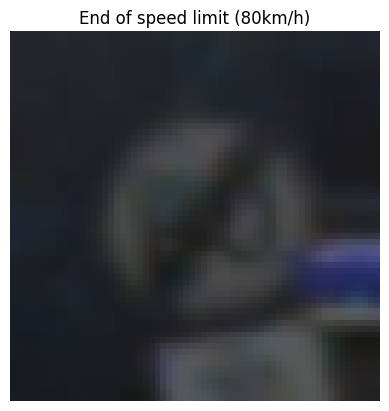

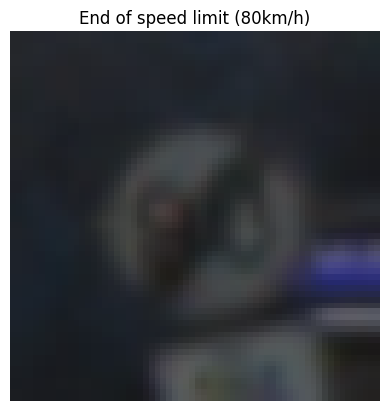

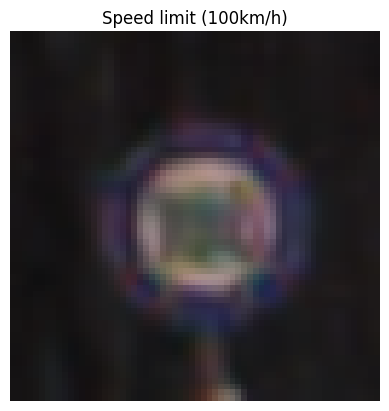

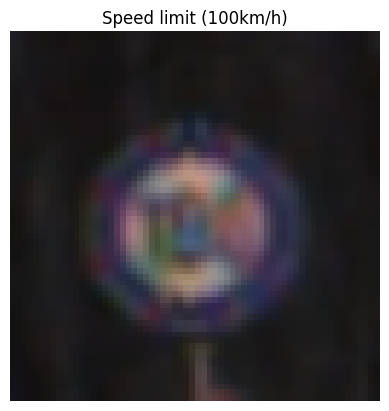

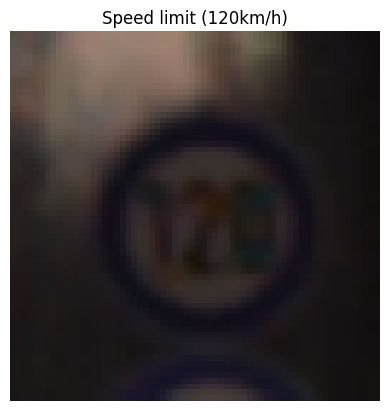

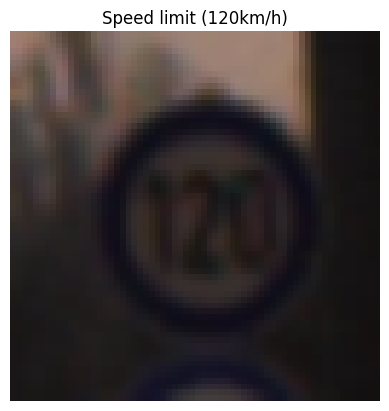

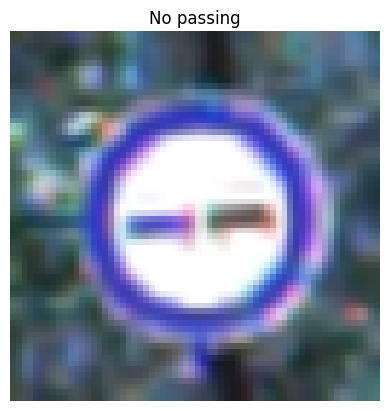

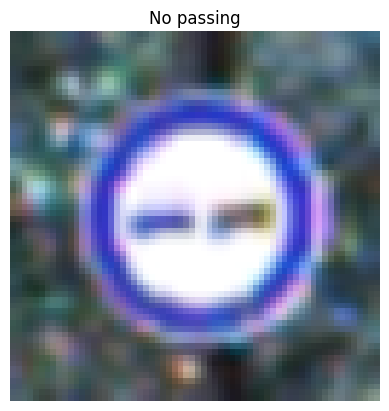

In [9]:
#Visualization

# plot histogram of pixel values
def plot_histogram(image_tensor):
    flattened_image = image_tensor.view(-1)
    plt.hist(flattened_image.numpy(), bins=50, alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Values')
    plt.show()

# Displaying few images of each class
def display_images(dataset, class_names, num_images=2):
    for i, class_name in enumerate(class_names):
        indices = np.where(np.array(dataset.targets) == i)[0]
        indices = indices[:num_images] if len(indices) > num_images else indices
        for index in indices:
            image, _ = dataset[index]
            # image = visualize_transform(image)
            plt.title(class_name)
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.show()

# label mapping
class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection',
               'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution',
               'Dangerous curve to the left', 'Speed limit (50km/h)', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road',
               'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing',
               'Speed limit (60km/h)', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead',
               'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Speed limit (70km/h)',
               'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons', 'Speed limit (80km/h)',
               'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)','No passing']

# Plot histogram of pixel values
sample_image, _ = trainSet[0]
plot_histogram(sample_image)

# Display a few images for each category
display_images(trainSet, class_names)


In [10]:
# Saving Weights
def save_best_weights(model, filename):
    with h5py.File(filename, 'w') as fi:
        for name, param in model.state_dict().items():
             fi.create_dataset(name, data=param.cpu().numpy())

VGG13 Model:

In [11]:
# VGG13 Model with Optimization Techniques

# Defining VGG-13 CNN architecture
class VGG(nn.Module):
    def __init__(self, num_classes=43):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Creating a VGG model instance
vgg13_opt_model = VGG(num_classes=43)

# Display the model architecture
vgg13_opt_model

# Moving the model to GPU
vgg13_opt_model = vgg13_opt_model.cuda()

# Displaying model summary
summary(vgg13_opt_model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4           [-1, 64, 64, 64]          36,928
              ReLU-5           [-1, 64, 64, 64]               0
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
              ReLU-9          [-1, 128, 32, 32]               0
      BatchNorm2d-10          [-1, 128, 32, 32]             256
           Conv2d-11          [-1, 128, 32, 32]         147,584
             ReLU-12          [-1, 128, 32, 32]               0
      BatchNorm2d-13          [-1, 128, 32, 32]             256
        MaxPool2d-14          [-1, 128,

In [12]:

# Define loss function and optimizer with L2 regularization
vgg13_opt_criterion = nn.CrossEntropyLoss()
vgg13_opt_optimizer = optim.SGD(vgg13_opt_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Define L2 regularization function
# def l2_regularization(model, lambda_l2=0.01):
#     l2_reg = torch.tensor(0., device=device)
#     for param in model.parameters():
#         l2_reg += torch.norm(param)
#     return lambda_l2 * l2_reg

# A Variable to keep track of the best validation loss
vgg13_opt_best_val_loss = float('inf')

# Variable to keep track of the number of epochs without improvement and a counter
vgg13_opt_early_stopping_patience = 3
vgg13_opt_early_stopping_counter = 0

# Lists to store accuracies and losses of each subset of all epochs
vgg13_opt_train_accuracies = []
vgg13_opt_train_losses = []
vgg13_opt_validation_accuracies = []
vgg13_opt_validation_losses = []
vgg13_opt_test_accuracies = []
vgg13_opt_test_losses = []
vgg13_opt_num_epochs = 10

# Training loop with early stopping
vgg13_opt_start_time = time.time()
for epoch in range(vgg13_opt_num_epochs):
    vgg13_opt_train_loss = 0.0
    vgg13_opt_train_crct = 0
    vgg13_opt_train_tot = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
        vgg13_opt_optimizer.zero_grad()
        outputs = vgg13_opt_model(inputs)
        labels = labels.view(-1)
        vgg13_opt_loss = vgg13_opt_criterion(outputs, labels) #+ l2_regularization(vgg13_opt_model)
        vgg13_opt_train_loss += vgg13_opt_loss
        vgg13_opt_loss.backward()
        vgg13_opt_optimizer.step()
        _, preds = torch.max(outputs, 1)
        vgg13_opt_train_tot += labels.size(0)
        vgg13_opt_train_crct += (preds == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{vgg13_opt_num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {vgg13_opt_train_loss.item():.4f}')
    vgg13_opt_train_loss /= len(train_loader)
    vgg13_opt_train_acc = 100 * vgg13_opt_train_crct / vgg13_opt_train_tot

    # Validating the model
    with torch.no_grad():
        vgg13_opt_val_loss = 0.0
        vgg13_opt_val_crct = 0
        vgg13_opt_val_tot = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
            outputs = vgg13_opt_model(inputs)
            labels = labels.view(-1)
            vgg13_opt_val_loss += vgg13_opt_criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            vgg13_opt_val_tot += labels.size(0)
            vgg13_opt_val_crct += (preds == labels).sum().item()
        vgg13_opt_val_loss /= len(val_loader)
        vgg13_opt_val_acc = 100 * vgg13_opt_val_crct / vgg13_opt_val_tot

    # Evaluating our model on test data
    vgg13_opt_all_preds = []
    vgg13_opt_all_labels = []
    with torch.no_grad():
        vgg13_opt_test_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
            outputs = vgg13_opt_model(inputs)
            labels = labels.view(-1)
            vgg13_opt_test_loss += vgg13_opt_criterion(outputs, labels).item()
            # Apply softmax and calculate accuracy
            softmax_outputs = F.softmax(outputs, dim=1)
            _, preds = torch.max(softmax_outputs, 1)
            # _, preds = torch.max(outputs, 1)
            vgg13_opt_all_preds.extend(preds.tolist())
            vgg13_opt_all_labels.extend(labels.tolist())


        # Calculate metrics
        vgg13_opt_test_loss /= len(test_loader)
        vgg13_opt_test_acc = accuracy_score(vgg13_opt_all_labels, vgg13_opt_all_preds)*100
        vgg13_opt_precision, vgg13_opt_recall, vgg13_opt_f1, _ = precision_recall_fscore_support(vgg13_opt_all_labels, vgg13_opt_all_preds, average='weighted')

        # Displaying calculated evaluation metrics of our model
        print(f'Accuracy: {vgg13_opt_test_acc:.2f}%')
        print(f'Precision: {vgg13_opt_precision:.2f}')
        print(f'Recall: {vgg13_opt_recall:.2f}')
        print(f'F1 Score: {vgg13_opt_f1:.2f}')

    vgg13_opt_train_accuracies.append(vgg13_opt_train_acc)
    vgg13_opt_train_losses.append(vgg13_opt_train_loss)
    vgg13_opt_validation_accuracies.append(vgg13_opt_val_acc)
    vgg13_opt_validation_losses.append(vgg13_opt_val_loss)
    vgg13_opt_test_accuracies.append(vgg13_opt_test_acc)
    vgg13_opt_test_losses.append(vgg13_opt_test_loss)

    # Check if the validation loss has improved
    if vgg13_opt_val_loss < vgg13_opt_best_val_loss:
        vgg13_opt_best_val_loss = vgg13_opt_val_loss
        vgg13_opt_early_stopping_counter = 0
        # Save the best model if improved
        torch.save(vgg13_opt_model.state_dict(), 'best_vgg13_opt_model.pth')
        save_best_weights(vgg13_opt_model, 'vgg13_opt_model_weights.h5')
    else:
        vgg13_opt_early_stopping_counter += 1

    #  Stop training the model if the validation loss does not improve for 'early_stopping_patience' epochs
    if vgg13_opt_early_stopping_counter >= vgg13_opt_early_stopping_patience:
        print("Early stopping after {} epochs without improvement.".format(vgg13_opt_early_stopping_patience))
        break

vgg13_opt_send_time=time.time()
# Loading the best model for evaluation
vgg13_opt_model.load_state_dict(torch.load('best_vgg13_opt_model.pth'))
vgg13_opt_model.eval()

print("Time to Train: ", vgg13_opt_send_time-vgg13_opt_start_time)
print("Train Accuracies: ",vgg13_opt_train_accuracies)
print("Train Losses: ",vgg13_opt_train_losses)
print("Test Accuracies: ",vgg13_opt_test_accuracies)
print("Test Losses: ",vgg13_opt_test_losses)
print("Validation Accuracies: ",vgg13_opt_validation_accuracies)
print("Validation Losses: ",vgg13_opt_validation_losses)



Epoch [1/10], Step [100/214], Loss: 361.9337
Epoch [1/10], Step [200/214], Loss: 676.4379


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 21.04%
Precision: 0.22
Recall: 0.21
F1 Score: 0.17
Epoch [2/10], Step [100/214], Loss: 265.9470
Epoch [2/10], Step [200/214], Loss: 472.3326


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 47.13%
Precision: 0.48
Recall: 0.47
F1 Score: 0.43
Epoch [3/10], Step [100/214], Loss: 151.8613
Epoch [3/10], Step [200/214], Loss: 262.6292
Accuracy: 76.67%
Precision: 0.79
Recall: 0.77
F1 Score: 0.75
Epoch [4/10], Step [100/214], Loss: 62.1281
Epoch [4/10], Step [200/214], Loss: 99.1854
Accuracy: 94.14%
Precision: 0.95
Recall: 0.94
F1 Score: 0.94
Epoch [5/10], Step [100/214], Loss: 18.0515
Epoch [5/10], Step [200/214], Loss: 31.0480
Accuracy: 98.36%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Epoch [6/10], Step [100/214], Loss: 6.9497
Epoch [6/10], Step [200/214], Loss: 12.3804
Accuracy: 98.18%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Epoch [7/10], Step [100/214], Loss: 3.7436
Epoch [7/10], Step [200/214], Loss: 6.0849
Accuracy: 98.94%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Epoch [8/10], Step [100/214], Loss: 1.8153
Epoch [8/10], Step [200/214], Loss: 3.1784
Accuracy: 99.30%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Epoch [9/10], Step [100/214], Loss: 2.1682
Epoch

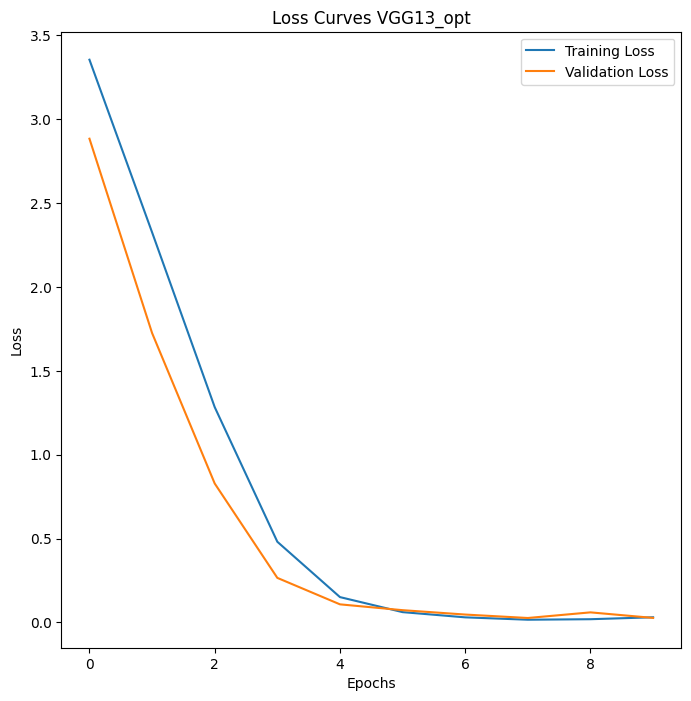

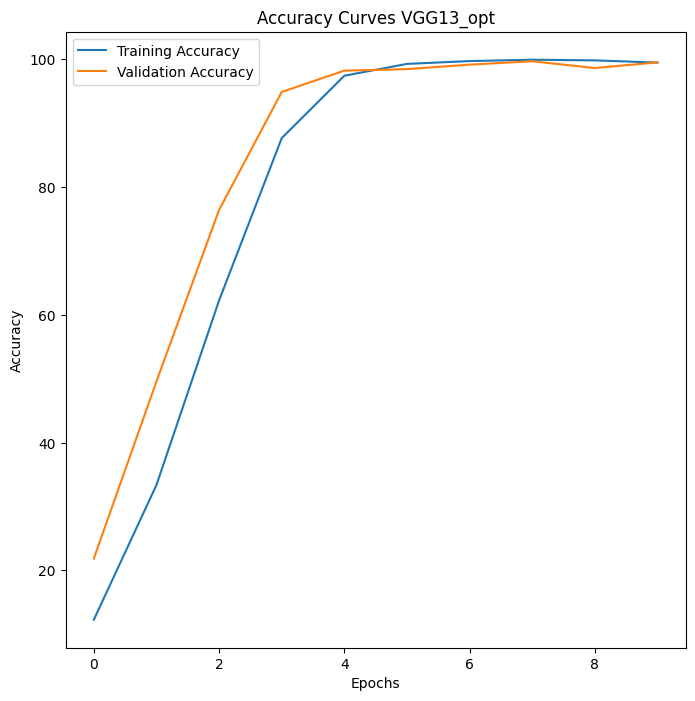

In [13]:
# Loss curves for VGG13_opt

vgg13_opt_train_losses_tensor = torch.tensor(vgg13_opt_train_losses)
vgg13_opt_validation_losses_tensor = torch.tensor(vgg13_opt_validation_losses)
# vgg13_opt_test_losses_tensor = torch.tensor(vgg13_opt_test_losses)

vgg13_opt_train_losses_cpu = vgg13_opt_train_losses_tensor.cpu().numpy()
vgg13_opt_validation_losses_cpu = vgg13_opt_validation_losses_tensor.cpu().numpy()
# vgg13_opt_test_losses_cpu = vgg13_opt_test_losses_tensor.cpu().numpy()

plt.figure(figsize=(8, 8))
plt.plot(vgg13_opt_train_losses_cpu, label="Training Loss")
plt.plot(vgg13_opt_validation_losses_cpu, label="Validation Loss")
# plt.plot(vgg13_opt_test_losses_cpu, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves VGG13_opt")

plt.show()

# Accuracy curves for VGG13_opt

vgg13_opt_train_accuracies_tensor = torch.tensor(vgg13_opt_train_accuracies)
vgg13_opt_validation_accuracies_tensor = torch.tensor(vgg13_opt_validation_accuracies)
# vgg13_opt_test_accuracies_tensor = torch.tensor(vgg13_opt_test_accuracies)

vgg13_opt_train_accuracies_cpu = vgg13_opt_train_accuracies_tensor.cpu().numpy()
vgg13_opt_validation_accuracies_cpu = vgg13_opt_validation_accuracies_tensor.cpu().numpy()
# vgg11_opt_test_accuracies_cpu = vgg11_opt_test_accuracies_tensor.cpu().numpy()

plt.figure(figsize=(8, 8))
plt.plot(vgg13_opt_train_accuracies_cpu, label="Training Accuracy")
plt.plot(vgg13_opt_validation_accuracies_cpu, label="Validation Accuracy")
# plt.plot(vgg13_opt_test_accuracies_cpu, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves VGG13_opt")

plt.show()

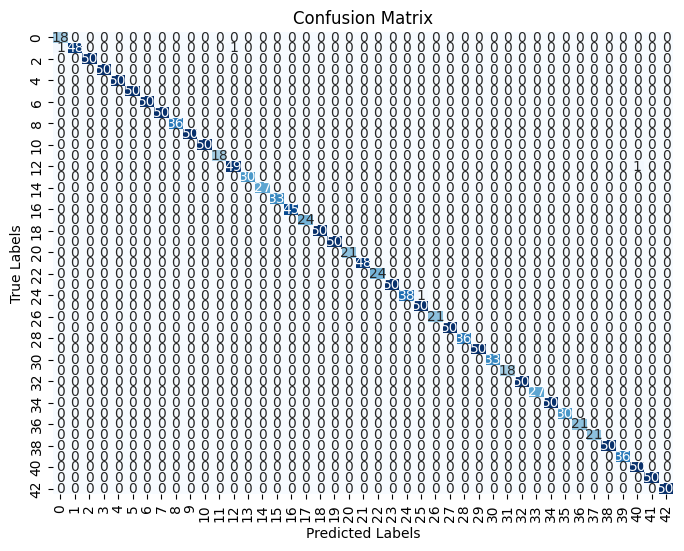

In [14]:
# Confusion Matrix for VGG13_opt

conf_matrix = confusion_matrix(vgg13_opt_all_labels, vgg13_opt_all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

ResNet18 Model:

In [15]:
# Defining Resnet18 Architecture

# Define the residual block
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        #images are stored in identity to be added to output
        identity = x
        #first block
        out = self.relu(self.bn1(self.conv1(x)))
        #second block
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)
        #add identity to retain original input
        out = self.relu(out + identity)
        return out


# Define the ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, block, layers, num_classes=43):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.add_layer(block, 64, layers[0])
        self.layer2 = self.add_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.add_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.add_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def add_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the ResNet-18 model
resnet18 = ResNet18(ResidualBlock, [2, 2, 2, 2])
resnet18.to('cuda')


# # Print model summary
# print(resnet18)

# Displaying model summary
summary(resnet18, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
    ResidualBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [16]:
criterion = nn.CrossEntropyLoss()

# Define optimizer with weight decay
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-4)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Modify the training loop to include early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, patience=3, num_epochs=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improvement_count = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
            torch.save(model.state_dict(), 'resnet18_model.pth')
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(resnet18, train_loader, val_loader, criterion, optimizer, patience=2, num_epochs=3)

Epoch 1/3, Train Loss: 1.1098, Val Loss: 0.2726, Train Accuracy: 0.6800, Val Accuracy: 0.9185
Epoch 2/3, Train Loss: 0.1548, Val Loss: 0.1215, Train Accuracy: 0.9548, Val Accuracy: 0.9642
Epoch 3/3, Train Loss: 0.0890, Val Loss: 0.0804, Train Accuracy: 0.9730, Val Accuracy: 0.9713


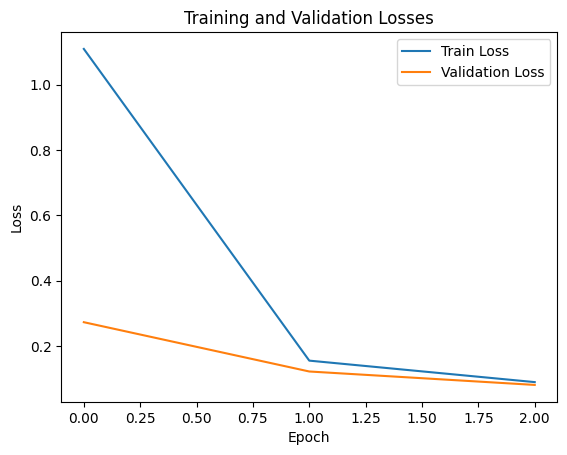

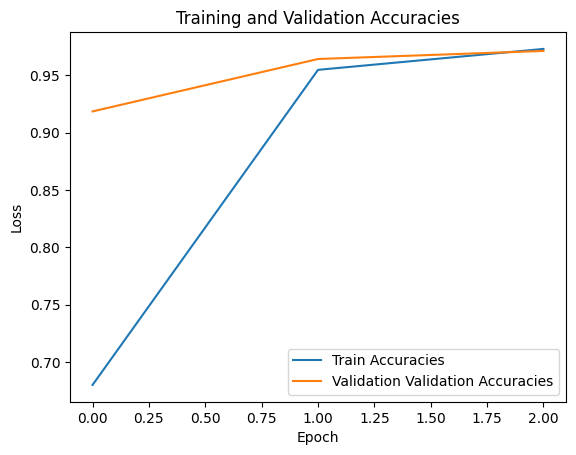

In [17]:
# Plot the training and validation losses

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracies')
plt.plot(val_accuracies, label='Validation Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

Test Accuracy: 97.12778429073857


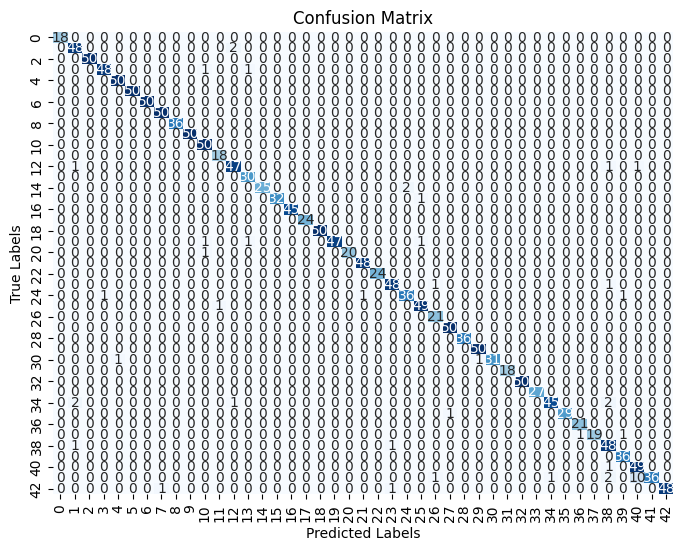

In [18]:
resnet18.eval()
test_losses = []
test_accuracies = []
test_predictions = []
true_labels = []

for images, labels in test_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs = resnet18(images)
    loss = criterion(outputs, labels)
    test_losses.append(loss.item())

    _, predicted = torch.max(outputs, 1)
    test_predictions.extend(predicted.cpu().tolist())
    true_labels.extend(labels.cpu().tolist())

# Calculate accuracy
accuracy = accuracy_score(true_labels, test_predictions)

# Display accuracy
print("Test Accuracy:", accuracy*100)

conf_matrix = confusion_matrix(true_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#Eval Metrics
def calculate_metrics(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return precision, recall, f1

# After training
precision_train, recall_train, f1_train = calculate_metrics(resnet18, train_loader)
precision_val, recall_val, f1_val = calculate_metrics(resnet18, val_loader)

print("Train Precision:", precision_train)
print("Train Recall:", recall_train)
print("Train F1 Score:", f1_train)

print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)
print("Validation F1 Score:", f1_val)

Train Precision: 0.9881601792796019
Train Recall: 0.986255574743947
Train F1 Score: 0.9867063753433284
Validation Precision: 0.9775164199712104
Validation Recall: 0.9697696231417161
Validation F1 Score: 0.9719134899148371


DenseNet Model:

In [20]:
# Defining DenseNet Architecture

class BottleneckLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out, x], 1)  # Concatenate along channels axis
        return out

# Defining Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Defining Dense Block
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.avg_pool(out)
        return out

# Defining DenseNet
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, num_classes=1000):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False))
        self.features.add_module('norm0', nn.BatchNorm2d(num_init_features))
        self.features.add_module('relu0', nn.ReLU(inplace=True))
        self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            self.features.add_module(f'denseblock{i + 1}', DenseBlock(num_features, growth_rate, num_layers))
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                out_channels = num_features // bn_size
                self.features.add_module(f'transition{i + 1}', TransitionLayer(num_features, out_channels))
                num_features = out_channels

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('pool5', nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

# instantiation of DenseNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet_model = DenseNet().to(device)
# print(densenet_model)
# densenet_model.summary()
summary(densenet_model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
       BatchNorm2d-5           [-1, 64, 16, 16]             128
            Conv2d-6          [-1, 128, 16, 16]           8,192
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8           [-1, 32, 16, 16]          36,864
   BottleneckLayer-9           [-1, 96, 16, 16]               0
      BatchNorm2d-10           [-1, 96, 16, 16]             192
           Conv2d-11          [-1, 128, 16, 16]          12,288
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13           [-1, 32, 16, 16]          36,864
  BottleneckLayer-14          [-1, 128,

In [21]:
# Define loss function and optimizer with L2 regularization
densenet_criterion = nn.CrossEntropyLoss()
densenet_optimizer = optim.SGD(densenet_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Define L2 regularization function
# def l2_regularization(model, lambda_l2=0.01):
#     l2_reg = torch.tensor(0., device=device)
#     for param in model.parameters():
#         l2_reg += torch.norm(param)
#     return lambda_l2 * l2_reg

# A Variable to keep track of the best validation loss
densenet_best_val_loss = float('inf')

# Variable to keep track of the number of epochs without improvement and a counter
densenet_early_stopping_patience = 3
densenet_early_stopping_counter = 0

# Lists to store accuracies and losses of each subset of all epochs
densenet_train_accuracies = []
densenet_train_losses = []
densenet_validation_accuracies = []
densenet_validation_losses = []
densenet_test_accuracies = []
densenet_test_losses = []
densenet_num_epochs = 10

# Training loop with early stopping
densenet_start_time = time.time()
for epoch in range(densenet_num_epochs):
    densenet_train_loss = 0.0
    densenet_train_crct = 0
    densenet_train_tot = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
        densenet_optimizer.zero_grad()
        outputs = densenet_model(inputs)
        labels = labels.view(-1)
        densenet_loss = densenet_criterion(outputs, labels) #+ l2_regularization(vgg13_opt_model)
        densenet_train_loss += densenet_loss
        densenet_loss.backward()
        densenet_optimizer.step()
        _, preds = torch.max(outputs, 1)
        densenet_train_tot += labels.size(0)
        densenet_train_crct += (preds == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{densenet_num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {densenet_train_loss.item():.4f}')
    densenet_train_loss /= len(train_loader)
    densenet_train_acc = 100 * densenet_train_crct / densenet_train_tot

    # Validating the model
    with torch.no_grad():
        densenet_val_loss = 0.0
        densenet_val_crct = 0
        densenet_val_tot = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
            outputs = densenet_model(inputs)
            labels = labels.view(-1)
            densenet_val_loss += densenet_criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            densenet_val_tot += labels.size(0)
            densenet_val_crct += (preds == labels).sum().item()
        densenet_val_loss /= len(val_loader)
        densenet_val_acc = 100 * densenet_val_crct / densenet_val_tot

    # Evaluating our model on test data
    densenet_all_preds = []
    densenet_all_labels = []
    with torch.no_grad():
        densenet_test_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Moving the inputs and labels to GPU
            outputs = densenet_model(inputs)
            labels = labels.view(-1)
            densenet_test_loss += densenet_criterion(outputs, labels).item()
            # Apply softmax and calculate accuracy
            softmax_outputs = F.softmax(outputs, dim=1)
            _, preds = torch.max(softmax_outputs, 1)
            # _, preds = torch.max(outputs, 1)
            densenet_all_preds.extend(preds.tolist())
            densenet_all_labels.extend(labels.tolist())


        # Calculate metrics
        densenet_test_loss /= len(test_loader)
        densenet_test_acc = accuracy_score(densenet_all_labels, densenet_all_preds)*100
        densenet_precision, densenet_recall, densenet_f1, _ = precision_recall_fscore_support(densenet_all_labels, densenet_all_preds, average='weighted')

        # Displaying calculated evaluation metrics of our model
        print(f'Accuracy: {densenet_test_acc:.2f}%')
        print(f'Precision: {densenet_precision:.2f}')
        print(f'Recall: {densenet_recall:.2f}')
        print(f'F1 Score: {densenet_f1:.2f}')

    densenet_train_accuracies.append(densenet_train_acc)
    densenet_train_losses.append(densenet_train_loss)
    densenet_validation_accuracies.append(densenet_val_acc)
    densenet_validation_losses.append(densenet_val_loss)
    densenet_test_accuracies.append(densenet_test_acc)
    densenet_test_losses.append(densenet_test_loss)

    # Check if the validation loss has improved
    if densenet_val_loss < densenet_best_val_loss:
        densenet_best_val_loss = densenet_val_loss
        densenet_early_stopping_counter = 0
        # Save the best model if improved
        torch.save(densenet_model.state_dict(), 'best_densenet_model.pth')
        save_best_weights(densenet_model, 'densenet_model_weights.h5')
    else:
        densenet_early_stopping_counter += 1

    #  Stop training the model if the validation loss does not improve for 'early_stopping_patience' epochs
    if densenet_early_stopping_counter >= densenet_early_stopping_patience:
        print("Early stopping after {} epochs without improvement.".format(densenet_early_stopping_patience))
        break

densenet_send_time=time.time()
# Loading the best model for evaluation
densenet_model.load_state_dict(torch.load('best_densenet_model.pth'))
densenet_model.eval()

print("Time to Train: ", densenet_send_time-densenet_start_time)
print("Train Accuracies: ",densenet_train_accuracies)
print("Train Losses: ",densenet_train_losses)
print("Test Accuracies: ",densenet_test_accuracies)
print("Test Losses: ",densenet_test_losses)
print("Validation Accuracies: ",densenet_validation_accuracies)
print("Validation Losses: ",densenet_validation_losses)



Epoch [1/10], Step [100/214], Loss: 570.3659
Epoch [1/10], Step [200/214], Loss: 938.9030


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 25.44%
Precision: 0.28
Recall: 0.25
F1 Score: 0.22
Epoch [2/10], Step [100/214], Loss: 276.4370
Epoch [2/10], Step [200/214], Loss: 497.0333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 50.23%
Precision: 0.52
Recall: 0.50
F1 Score: 0.47
Epoch [3/10], Step [100/214], Loss: 162.9688
Epoch [3/10], Step [200/214], Loss: 290.5827


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 69.93%
Precision: 0.70
Recall: 0.70
F1 Score: 0.68
Epoch [4/10], Step [100/214], Loss: 94.1661
Epoch [4/10], Step [200/214], Loss: 168.3518
Accuracy: 83.82%
Precision: 0.84
Recall: 0.84
F1 Score: 0.83
Epoch [5/10], Step [100/214], Loss: 54.5032
Epoch [5/10], Step [200/214], Loss: 94.2240
Accuracy: 90.97%
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Epoch [6/10], Step [100/214], Loss: 26.8082
Epoch [6/10], Step [200/214], Loss: 50.0389
Accuracy: 95.31%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Epoch [7/10], Step [100/214], Loss: 18.2415
Epoch [7/10], Step [200/214], Loss: 32.5276
Accuracy: 96.31%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Epoch [8/10], Step [100/214], Loss: 11.7289
Epoch [8/10], Step [200/214], Loss: 21.2038
Accuracy: 97.42%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Epoch [9/10], Step [100/214], Loss: 8.9641
Epoch [9/10], Step [200/214], Loss: 16.6714
Accuracy: 97.36%
Precision: 0.98
Recall: 0.97
F1 Score: 0.97
Epoch [10/10], Step [100/214], Loss: 6.5751
E

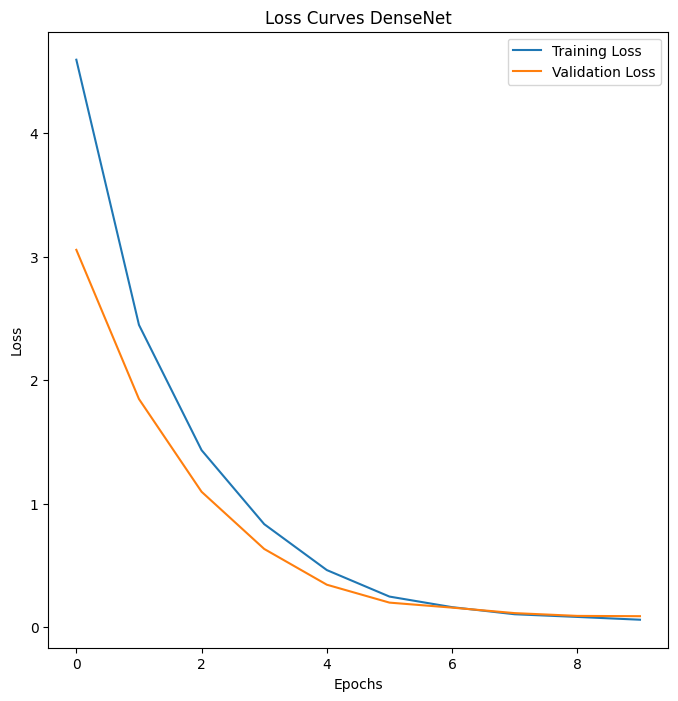

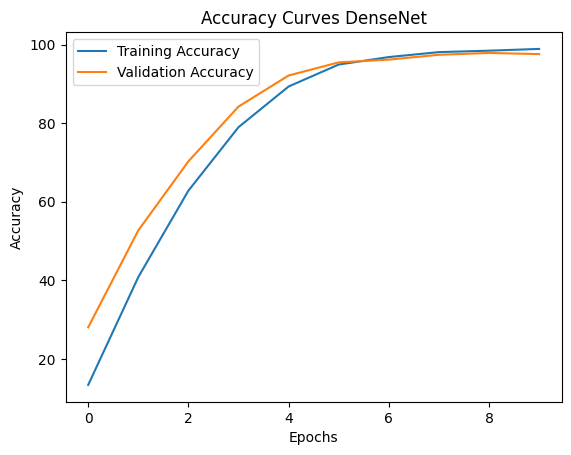

In [22]:
# Loss curves for DenseNet

densenet_train_losses_tensor = torch.tensor(densenet_train_losses)
densenet_validation_losses_tensor = torch.tensor(densenet_validation_losses)
# vgg13_opt_test_losses_tensor = torch.tensor(vgg13_opt_test_losses)

densenet_train_losses_cpu = densenet_train_losses_tensor.cpu().numpy()
densenet_validation_losses_cpu = densenet_validation_losses_tensor.cpu().numpy()
# vgg13_opt_test_losses_cpu = vgg13_opt_test_losses_tensor.cpu().numpy()

plt.figure(figsize=(8, 8))
plt.plot(densenet_train_losses_cpu, label="Training Loss")
plt.plot(densenet_validation_losses_cpu, label="Validation Loss")
# plt.plot(vgg13_opt_test_losses_cpu, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves DenseNet")

plt.show()

# Accuracy curves for DenseNet

densenet_train_accuracies_tensor = torch.tensor(densenet_train_accuracies)
densenet_validation_accuracies_tensor = torch.tensor(densenet_validation_accuracies)
# vgg13_opt_test_accuracies_tensor = torch.tensor(vgg13_opt_test_accuracies)

densenet_train_accuracies_cpu = densenet_train_accuracies_tensor.cpu().numpy()
densenet_validation_accuracies_cpu = densenet_validation_accuracies_tensor.cpu().numpy()
# vgg11_opt_test_accuracies_cpu = vgg11_opt_test_accuracies_tensor.cpu().numpy()

# plt.figure(figsize=(8, 8))
plt.plot(densenet_train_accuracies_cpu, label="Training Accuracy")
plt.plot(densenet_validation_accuracies_cpu, label="Validation Accuracy")
# plt.plot(vgg13_opt_test_accuracies_cpu, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves DenseNet")

plt.show()

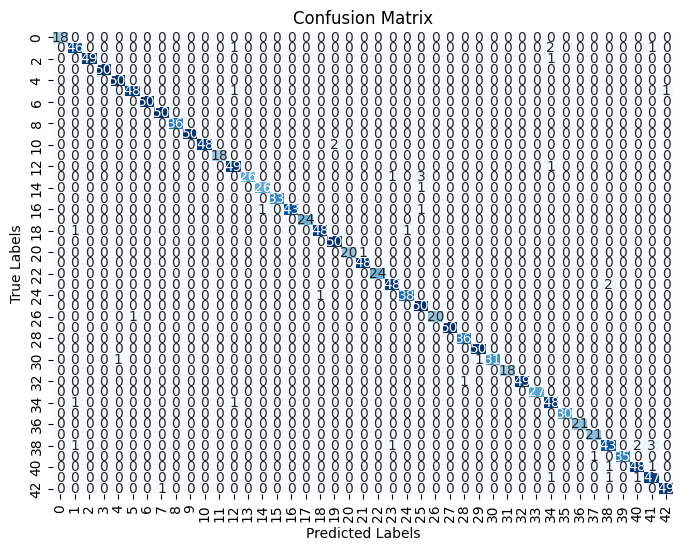

In [23]:
# Confusion Matrix for DenseNet
conf_matrix = confusion_matrix(densenet_all_labels, densenet_all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

GoogleNet Model:

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Inception module
class inception_block(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(inception_block, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

class google_net_model(nn.Module):
    def __init__(self, no_of_classes):
        super(google_net_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, no_of_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

no_of_classes = 43
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Gnet_model = google_net_model(no_of_classes).to(device)


In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Gnet_model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    Gnet_model.train()
    current_loss = 0.0
    correctly_predicted = 0
    total_predicted = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = Gnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_predicted += labels.size(0)
        correctly_predicted += (predicted == labels).sum().item()

    epoch_loss = current_loss / len(trainSet)
    training_accu = correctly_predicted / total_predicted
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accu)

    Gnet_model.eval()
    valid_correctly_predicted = 0
    valid_total_predicted = 0
    val_current_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = Gnet_model(images)
            val_loss = criterion(outputs, labels)
            val_current_loss += val_loss.item() * images.size(0)
            _, val_predicted = torch.max(outputs, 1)
            valid_total_predicted += labels.size(0)
            valid_correctly_predicted += (val_predicted == labels).sum().item()

    val_loss = val_current_loss / len(valSet)
    val_acc = valid_correctly_predicted / valid_total_predicted

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Iteration [{epoch+1}/{num_epochs}], '
      f'Training Loss: {epoch_loss*100:.4f}, Training Accuracy: {training_accu*100:.4f}%, '
      f'Validation Loss: {val_loss*100:.4f}, Validation Accuracy: {val_acc*100:.4f}%')



Iteration [1/10], Training Loss: 352.7834, Training Accuracy: 8.0744%, Validation Loss: 322.4911, Validation Accuracy: 15.1231%
Iteration [2/10], Training Loss: 287.3504, Training Accuracy: 22.7433%, Validation Loss: 261.0873, Validation Accuracy: 26.4947%
Iteration [3/10], Training Loss: 210.9655, Training Accuracy: 40.4528%, Validation Loss: 238.4985, Validation Accuracy: 31.9461%
Iteration [4/10], Training Loss: 141.7107, Training Accuracy: 60.4997%, Validation Loss: 148.5426, Validation Accuracy: 58.4994%
Iteration [5/10], Training Loss: 83.6361, Training Accuracy: 77.4326%, Validation Loss: 72.9073, Validation Accuracy: 80.0117%
Iteration [6/10], Training Loss: 48.1189, Training Accuracy: 87.5073%, Validation Loss: 48.3940, Validation Accuracy: 86.4009%
Iteration [7/10], Training Loss: 27.9154, Training Accuracy: 93.1638%, Validation Loss: 27.1036, Validation Accuracy: 92.9074%
Iteration [8/10], Training Loss: 16.0221, Training Accuracy: 96.5050%, Validation Loss: 21.8565, Validat

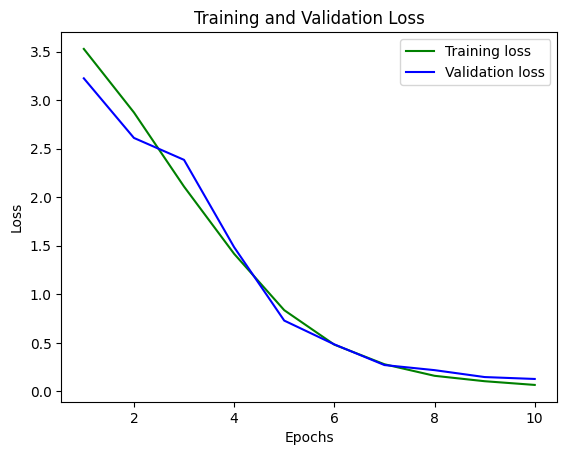

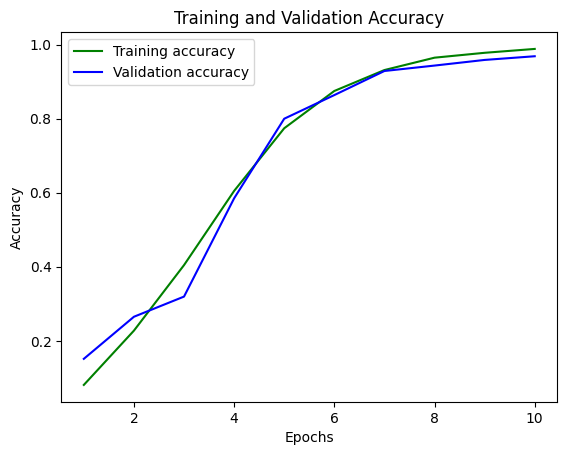

In [26]:
epochs = range(1, num_epochs + 1)

# Plotting training and validation loss
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [27]:
# Test the model
Gnet_model.eval()
test_correctly_predicted = 0
test_total_predicted = 0
test_current_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()  # Move data to GPU
        outputs = Gnet_model(images)
        test_loss = criterion(outputs, labels)
        test_current_loss += test_loss.item() * images.size(0)
        _, test_predicted = torch.max(outputs, 1)
        test_total_predicted += labels.size(0)
        test_correctly_predicted += (test_predicted == labels).sum().item()

test_loss = test_current_loss / len(test_loader.dataset)
test_acc = test_correctly_predicted / test_total_predicted

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Test Loss: 0.1196, Test Accuracy: 0.9678


In [28]:
from sklearn.metrics import precision_recall_fscore_support
import torch

# Make sure model is in eval mode for inference
Gnet_model.eval()

true_labels = []
predictions = []

# No gradient needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = Gnet_model(inputs)

        # Convert outputs to predicted class
        _, preds = torch.max(outputs, 1)

        # Extend our lists
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

# For multiclass, using 'weighted' to account for label imbalance
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.9704379911251443
Recall: 0.9677608440797186
F1 Score: 0.967872939607695


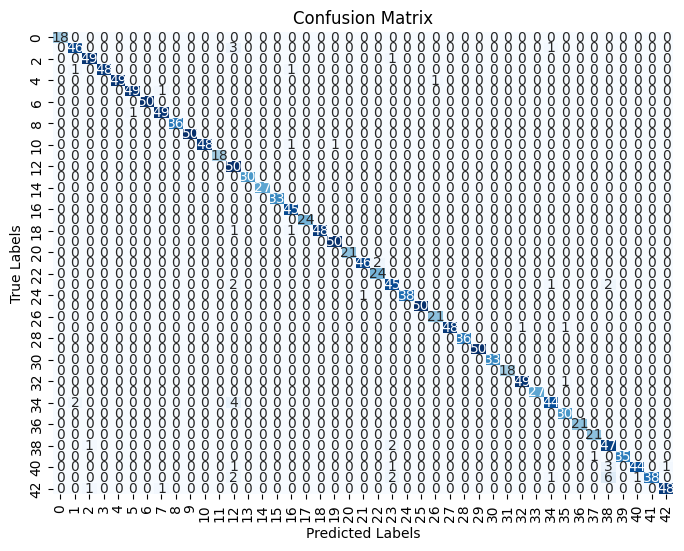

In [29]:
# Confusion Matrix for GoogleNet
Gnet_model.eval()
test_losses = []
test_accuracies = []
test_predictions = []
true_labels = []

for images, labels in test_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs = Gnet_model(images)
    loss = criterion(outputs, labels)
    test_losses.append(loss.item())

    _, predicted = torch.max(outputs, 1)
    test_predictions.extend(predicted.cpu().tolist())
    true_labels.extend(labels.cpu().tolist())

conf_matrix = confusion_matrix(true_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()